In [1]:
!where python

c:\Users\HK-Laptop-V639\Documents\GitHub\696\env696\Scripts\python.exe
C:\Users\HK-Laptop-V639\AppData\Local\Programs\Python\Python312\python.exe
C:\Users\HK-Laptop-V639\AppData\Local\Microsoft\WindowsApps\python.exe


In [2]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)

In [3]:
# fix random state
import os
RANDOM_SEED = 123
os.environ["OMP_NUM_THREADS"] = "1"
np.random.seed(42)
import torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
# import necessary assets
import joblib

train_dl = joblib.load('assets/train_deep_learning_with_theme.joblib')
test_dl = joblib.load('assets/test_deep_learning_with_theme.joblib')

In [5]:
train_dl.sample(5)

,title,type,score,scored_by,status,episodes/chapters,source,members,favorites,sfw,genres,themes,demographics,creators,production_source,synopsis,title_english,title_japanese,is_anime,start_year,end_year,start_season,end_season,topic_BERTopic_score,theme_assigned
17547,"Gokigen You, Koharu-san",manga,6.62,141,currently_publishing,NaN,NaN,683,1,True,[Romance],[],[Shoujo],[Kanae Hazuki],[Dessert],"Outside of working at a maid cafe, 19-year-old...","How Do You Do, Koharu?",ごきげんよう、小春さん,0,2019.0,NaN,Spring,NaN,0.442455,"Adult Life, Work, and Relationships"
21580,Sei no Mamono,manga,NaN,29,finished,7.0,NaN,101,1,False,[Hentai],[],[],[flanvia],[Comic X-Eros],1. Natsu no Mamono\r\n2. Haru no Mamono\r\n3. ...,The Sexual Demon,性のマモノ,0,2018.0,2020.0,Spring,Summer,0.004025,Romance with sensitive content
6335,Doukyuusei (OVA): Natsu no Owari ni,ova,5.55,806,finished_airing,4.0,visual_novel,2987,7,False,"[Drama, Hentai, Romance]",[Harem],[],[Arms],['Pink Pineapple'],Using state of the art animation End Of Summer...,End of Summer,同級生 夏の終わりに,1,1994.0,1995.0,Summer,Spring,0.342129,"Light-Hearted, Mixed-Genre Shorts and Specials"
9189,Tate no Yuusha no Nariagari,light_novel,7.97,15898,currently_publishing,NaN,NaN,45467,1749,True,[Fantasy],[Isekai],[],"[Yusagi Aneko, Seira Minami]",[],Stories of old tell of four otherworldly heroe...,The Rising of the Shield Hero,盾の勇者の成り上がり,0,2013.0,NaN,Summer,NaN,0.452389,Fantasy Adventure / Isekai (alternate world)
15210,Kowloons' Ball Parade,manga,5.96,1496,finished,22.0,NaN,2478,4,True,[Sports],[Team Sports],[Shounen],"[Ashibi Fukui, Mikiyasu Kamada]",[Shounen Jump (Weekly)],Hakuo Gakuin's mighty baseball team consistent...,Nine Dragons' Ball Parade,クーロンズ・ボール・パレード,0,2021.0,2021.0,Winter,Summer,0.024548,Sports and Club Activities


In [6]:
train_dl.shape

(19453, 25)

In [7]:
train_dl_score = train_dl.dropna(subset='score').copy()
train_dl_score.shape

(13484, 25)

In [8]:
train_dl_popularity = train_dl.dropna(subset='members').copy()
train_dl_popularity.shape

(19453, 25)

In [9]:
import matplotlib.pyplot as plt

def outliers_evaluation(target, threshold = 3):
    df = train_dl_score if target == 'score' else train_dl_popularity

    mean = np.mean(df[target])
    std = np.std(df[target])

    outliers = np.abs(df[target] - mean) > threshold * std
    num_outliers = np.sum(outliers)

    print(f"Number of outliers: {num_outliers} ")
    print(f"proportion: {num_outliers / len(df[target])}")

    # Boxplot to visually identify outliers
    plt.boxplot(df[target])
    plt.title("Boxplot of Target Variable")
    plt.show()

Number of outliers: 92 
proportion: 0.006822901216256304


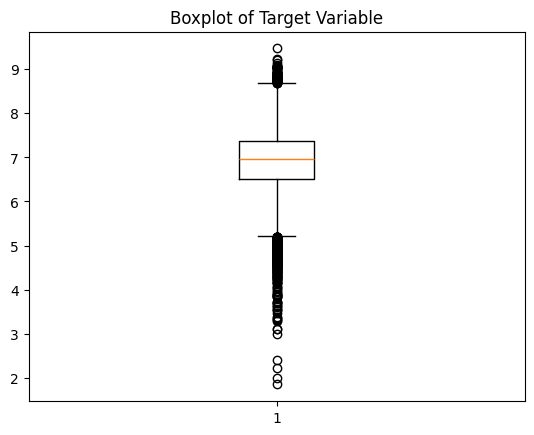

In [10]:
outliers_evaluation('score')

Number of outliers: 320 
proportion: 0.016449904898987303


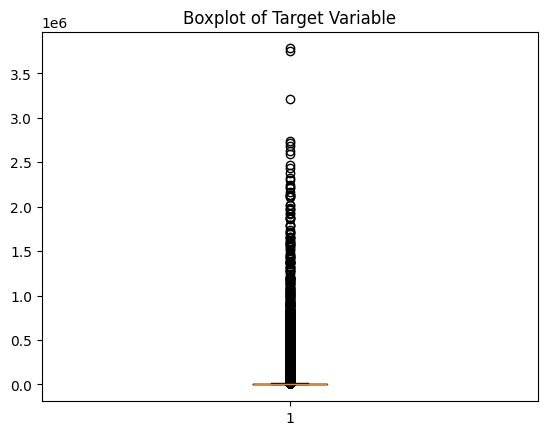

In [11]:
outliers_evaluation('members')

# Score prediction

In [12]:
single_cat_columns = ['type', 'status', 'source', 'start_season', 'end_season', 'theme_assigned']
#multi_cat_columns = ['genres', 'demographics', 'creators', 'production_source']
multi_cat_columns = ['genres', 'demographics', 'creators']
numeric_columns = ['score', 'scored_by', 'episodes/chapters', 'members', 'favorites', 'start_year', 'end_year', 'topic_BERTopic_score']
#boolean_columns = ['sfw', 'is_anime']
boolean_columns = ['sfw']

## Pre-processing

1. Handle Missing Values for Single Categorical Columns: Fill with 'Missing'.
2. Label Encode Single Categorical and Multi-Categorical Columns.
3. Pad Multi-Categorical Columns with 0 after label encoding.
4. Use KNN Imputation for numerical columns using all categorical and boolean columns as features for imputation.
5. Standardize the imputed numerical columns.
6. Pass through PyTorch model with embeddings for categorical features and dense layers for numerical features.

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

# Step 1: Handle Missing Values in Single Categorical Columns
for col in single_cat_columns:
    train_dl_score[col] = train_dl_score[col].fillna('Missing')

# Step 2: Label Encode Single Categorical Columns
label_encoders = {}
for col in single_cat_columns:
    le = LabelEncoder()
    train_dl_score[col + '_encoded'] = le.fit_transform(train_dl_score[col])
    label_encoders[col] = le

# Step 3: Label Encode and Pad Multi-Categorical Columns
for col in multi_cat_columns:
    all_categories = set(item for sublist in train_dl_score[col] for item in sublist)  # Set of unique categories
    le = LabelEncoder().fit(list(all_categories))
    
    # Label encode each element in the list
    train_dl_score[col + '_encoded'] = train_dl_score[col].apply(lambda x: le.transform(x).tolist())
    
    # Pad sequences with 0 (padding index)
    padded_sequences = pad_sequence(
        [torch.tensor(row, dtype=torch.int64) for row in train_dl_score[col + '_encoded']],
        batch_first=True, padding_value=0
    )
    
    # Convert padded sequences into a list of tensors (1D arrays)
    train_dl_score[col + '_encoded_padded'] = list(padded_sequences.numpy())

In [14]:
train_dl_score.sample(3)

,title,type,score,scored_by,status,episodes/chapters,source,members,favorites,sfw,genres,themes,demographics,creators,production_source,synopsis,title_english,title_japanese,is_anime,start_year,end_year,start_season,end_season,topic_BERTopic_score,theme_assigned,type_encoded,status_encoded,source_encoded,start_season_encoded,end_season_encoded,theme_assigned_encoded,genres_encoded,genres_encoded_padded,demographics_encoded,demographics_encoded_padded,creators_encoded,creators_encoded_padded
10980,Renai Sample,manga,7.43,1229,finished,11.0,Missing,3137,48,False,[Hentai],[],[],[Homunculus],[Comic Kairaku-ten],1. Bikini no Housoku\r\n2. I Lock You!\r\n3. N...,Renai Sample,レンアイサンプル,0,2011.0,2013.0,Spring,Summer,0.003687,Romance with sensitive content,3,3,1,2,3,6,[12],"[12, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[],"[0, 0]",[1740],"[1740, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5452,The Marginal Service,tv,5.49,5003,finished_airing,12.0,original,19522,66,True,"[Action, Sci-Fi]",[Adult Cast],[],[Studio 3Hz],"['Shochiku', 'Movic', 'Nippon Television Netwo...",Foolhardy police officer Brian Nightraider is ...,The Marginal Service,THE MARGINAL SERVICE,1,2023.0,2023.0,Spring,Spring,0.003462,Action and Superpowers,13,4,10,2,2,0,"[0, 16]","[0, 16, 0, 0, 0, 0, 0, 0, 0, 0]",[],"[0, 0]",[5401],"[5401, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11346,Giganto Makhia,manga,7.01,8620,finished,7.0,Missing,16556,90,True,[Fantasy],[],[Seinen],[Kentarou Miura],[Young Animal],"In a future one hundred million years away, af...",Giganto Maxia,ギガントマキア ΓΙΓΑΝΤΟ ΜΑΧΙΑ,0,2013.0,2014.0,Autumn,Winter,0.439798,Fantasy Adventure / Isekai (alternate world),3,3,1,0,4,2,[9],"[9, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[2],"[2, 0]",[2608],"[2608, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [15]:
# Step 4: KNN Imputation for Numerical Columns
# Use all categorical and boolean columns (label-encoded) for imputation
imputation_features = [col + '_encoded' for col in single_cat_columns] + boolean_columns
knn_imputer = KNNImputer(n_neighbors=5)

# Combine categorical, boolean, and numeric columns for imputation
combined_data = np.hstack([train_dl_score[imputation_features].values, train_dl_score[numeric_columns].values])
imputed_data = knn_imputer.fit_transform(combined_data)

# Update the dataframe with imputed numerical values
train_dl_score[numeric_columns] = imputed_data[:, -len(numeric_columns):]

# Step 5: Standardize the Imputed Numerical Columns
scaler = StandardScaler()
train_dl_score[numeric_columns] = scaler.fit_transform(train_dl_score[numeric_columns])

In [16]:
train_dl_score.isnull().sum()

title                          0
type                           0
score                          0
scored_by                      0
status                         0
episodes/chapters              0
source                         0
members                        0
favorites                      0
sfw                            0
genres                         0
themes                         0
demographics                   0
creators                       0
production_source              0
synopsis                       0
title_english                  0
title_japanese                 0
is_anime                       0
start_year                     0
end_year                       0
start_season                   0
end_season                     0
topic_BERTopic_score           0
theme_assigned                 0
type_encoded                   0
status_encoded                 0
source_encoded                 0
start_season_encoded           0
end_season_encoded             0
theme_assi

In [17]:
numeric_columns.remove('score')

## Prepare PyTorch Dataset

In [ ]:
from torch.utils.data import Dataset

class AnimeMangaDataset(Dataset):
    def __init__(self, single_cat_inputs, multi_cat_inputs, numeric_inputs, boolean_inputs, target_scores):
        self.single_cat_inputs = single_cat_inputs
        self.multi_cat_inputs = multi_cat_inputs
        self.numeric_inputs = numeric_inputs
        self.boolean_inputs = boolean_inputs
        self.target_scores = target_scores

    def __len__(self):
        return len(self.target_scores)

    def __getitem__(self, idx):
        # For each sample, return the inputs and the corresponding target (score)
        single_cat_input = self.single_cat_inputs[idx]
        multi_cat_input = [multi_cat[idx] for multi_cat in self.multi_cat_inputs]  # Extract each multi-cat feature
        numeric_input = self.numeric_inputs[idx]
        boolean_input = self.boolean_inputs[idx]
        target = self.target_scores[idx]
        
        return single_cat_input, multi_cat_input, numeric_input, boolean_input, target
    
# Convert the target score into a tensor
target_scores = torch.tensor(train_dl_score['score'].values, dtype=torch.float32)

# Convert ALL single categorical columns into a tensor
single_cat_inputs = torch.tensor(train_dl_score[[col + '_encoded' for col in single_cat_columns]].values)

# Convert EACH multiple categorical column into a tensor
multi_cat_inputs = [
    torch.tensor(np.stack(train_dl_score[col + '_encoded_padded'].values), dtype=torch.int64)
    for col in multi_cat_columns
]

# Convert ALL numerical columns into a tensor
numeric_inputs = torch.tensor(train_dl_score[numeric_columns].values, dtype=torch.float32)

# Convert ALL boolean columns into a tensor
boolean_inputs = torch.tensor(train_dl_score[boolean_columns].values)

# Create an instance of the custom dataset
dataset = AnimeMangaDataset(single_cat_inputs, multi_cat_inputs, numeric_inputs, boolean_inputs, target_scores)

## Prepare Model

In [18]:
class AnimeMangaModel(nn.Module):
    def __init__(self, single_cat_dims, multi_cat_dims, embedding_dim, num_numeric, num_boolean):
        super(AnimeMangaModel, self).__init__()

        # Embedding layers for single categorical columns
        self.single_cat_embeddings = nn.ModuleList([
            nn.Embedding(cat_dim, embedding_dim) for cat_dim in single_cat_dims
        ])

        # Embedding layers for multi-categorical columns with padding
        self.multi_cat_embeddings = nn.ModuleList([
            nn.Embedding(cat_dim, embedding_dim, padding_idx=0) for cat_dim in multi_cat_dims
        ])

        # Dense layer for numeric and boolean inputs
        self.numeric_dense = nn.Linear(num_numeric, embedding_dim)
        self.boolean_dense = nn.Linear(num_boolean, embedding_dim)

        # Fully connected layers
        self.fc1 = nn.Linear(embedding_dim * (len(single_cat_dims) + len(multi_cat_dims) + 2), 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)  # Output for regression

    def forward(self, single_cat_inputs, multi_cat_inputs, numeric_inputs, boolean_inputs):
        # Process single categorical columns through embeddings
        single_cat_embeds = [
            embed(single_cat_inputs[:, i]) for i, embed in enumerate(self.single_cat_embeddings)
        ]
        
        # Process multi-categorical columns through embeddings with padding
        multi_cat_embeds = [
            torch.sum(embed(multi_cat_inputs[i]), dim=1) for i, embed in enumerate(self.multi_cat_embeddings)
        ]

        # Process numeric and boolean features through dense layers
        numeric_out = torch.relu(self.numeric_dense(numeric_inputs))
        boolean_out = torch.relu(self.boolean_dense(boolean_inputs.float()))

        # Concatenate all features together
        combined = torch.cat(single_cat_embeds + multi_cat_embeds + [numeric_out, boolean_out], dim=1)

        # Pass through fully connected layers
        x = torch.relu(self.fc1(combined))
        x = torch.relu(self.fc2(x))
        output = self.output(x)  # Regression output
        
        return output
    
# Dimensions for embedding layers
single_cat_dims = [train_dl_score[col + '_encoded'].nunique() for col in single_cat_columns]
multi_cat_dims = [train_dl_score[col + '_encoded_padded'].apply(lambda x: max(x)).max() + 1 for col in multi_cat_columns]

## Training Loop (with cross validation)

In [20]:
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from sklearn.model_selection import KFold

# Parameters
K_FOLDS = 5
NUM_EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EMBEDDING_DIM = 8

# Initialize the KFold object
kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)

targets = train_dl_score['score'].values

fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(targets)))):
    print(f"Fold {fold+1}/{K_FOLDS}")

    # Create Subsets for the current fold
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    # Create DataLoader for the training and validation set
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize a new model instance for each fold
    model = AnimeMangaModel(
        single_cat_dims=single_cat_dims,
        multi_cat_dims=multi_cat_dims,
        embedding_dim=EMBEDDING_DIM,
        num_numeric=len(numeric_columns),
        num_boolean=len(boolean_columns)
    )

    # Define the optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = torch.nn.MSELoss()

    # Training loop for the current fold
    for epoch in range(NUM_EPOCHS):
        model.train()
        train_loss = 0
        for batch in train_loader:
            single_cat_batch, multi_cat_batch, numeric_batch, boolean_batch, target_batch = batch
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            output = model(single_cat_batch, multi_cat_batch, numeric_batch, boolean_batch)
            
            # Compute loss
            loss = criterion(output.squeeze(), target_batch)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate training loss
            train_loss += loss.item()

        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss/len(train_loader)}")

    # Validation loop for the current fold
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            single_cat_batch, multi_cat_batch, numeric_batch, boolean_batch, target_batch = batch
            
            # Forward pass
            output = model(single_cat_batch, multi_cat_batch, numeric_batch, boolean_batch)
            
            # Compute loss
            loss = criterion(output.squeeze(), target_batch)
            
            # Accumulate validation loss
            val_loss += loss.item()
    
    # Average validation loss for this fold
    val_loss /= len(val_loader)
    print(f"Fold {fold+1}, Validation Loss: {val_loss}")
    
    # Store the validation loss for this fold
    fold_results.append(val_loss)

# Compute the average validation loss across all folds
average_val_loss = np.mean(fold_results)
print(f"Average Validation Loss Across {K_FOLDS} Folds: {average_val_loss}")

Fold 1/5
Epoch 1/10, Train Loss: 0.6743390667720659
Epoch 2/10, Train Loss: 0.515649243175278
Epoch 3/10, Train Loss: 0.45732733532345504
Epoch 4/10, Train Loss: 0.4193363345762682
Epoch 5/10, Train Loss: 0.3925790259030444
Epoch 6/10, Train Loss: 0.3692375737843076
Epoch 7/10, Train Loss: 0.3531936375347115
Epoch 8/10, Train Loss: 0.3355776599702045
Epoch 9/10, Train Loss: 0.32279232439733824
Epoch 10/10, Train Loss: 0.3070006591416675
Fold 1, Validation Loss: 0.417156744704527
Fold 2/5
Epoch 1/10, Train Loss: 0.6473995249211435
Epoch 2/10, Train Loss: 0.4793798634562002
Epoch 3/10, Train Loss: 0.4342183240154791
Epoch 4/10, Train Loss: 0.40455383917636417
Epoch 5/10, Train Loss: 0.3795845146186253
Epoch 6/10, Train Loss: 0.3615472789346819
Epoch 7/10, Train Loss: 0.342976965627374
Epoch 8/10, Train Loss: 0.3286573942860908
Epoch 9/10, Train Loss: 0.3126000522156439
Epoch 10/10, Train Loss: 0.3021411322189506
Fold 2, Validation Loss: 0.4059812068939209
Fold 3/5
Epoch 1/10, Train Loss: